## Setup

In [ ]:
!pip install -q ml_collections 

     |████████████████████████████████| 77 kB 3.1 MB/s 


## Assemble DINO weights in PyTorch

In [ ]:
import torch

In [ ]:
# Backbone
!wget https://dl.fbaipublicfiles.com/dino/dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth -q

# Linear layer
!wget https://dl.fbaipublicfiles.com/dino/dino_vitbase16_pretrain/dino_vitbase16_linearweights.pth -q

In [ ]:
backbone_state_dict = torch.load(
    "dino_vitbase16_pretrain.pth", map_location=torch.device("cpu")
)
linear_layer_state_dict = torch.load(
    "dino_vitbase16_linearweights.pth", map_location=torch.device("cpu")
)["state_dict"]

In [ ]:
# list(backbone_state_dict.keys())

In [ ]:
# list(linear_layer_state_dict.keys())

In [ ]:
backbone_state_dict.update(linear_layer_state_dict)
# list(backbone_state_dict.keys())

In [ ]:
backbone_state_dict["head.weight"] = backbone_state_dict.pop("module.linear.weight")
backbone_state_dict["head.bias"] = backbone_state_dict.pop("module.linear.bias")

## Setup model conversion utilities

In [ ]:
!git clone -q https://github.com/sayakpaul/deit-tf

In [ ]:
import sys
sys.path.append("deit-tf")

from vit.vit_models import ViTClassifier
from vit.model_configs import base_config
from utils import helpers
from vit.layers import mha

from tensorflow import keras
import tensorflow as tf

## A custom `ViTDINOBase` class to account for DINO's custom representation pooling

In [ ]:
class ViTDINOBase(ViTClassifier):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def call(self, inputs, training):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append class token if needed.
        if self.config.classifier == "token":
            cls_token = tf.tile(self.cls_token, (n, 1, 1))
            if cls_token.dtype != projected_patches.dtype:
                cls_token = tf.cast(cls_token, projected_patches.dtype)
            projected_patches = tf.concat([cls_token, projected_patches], axis=1)

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Initialize a dictionary to store attention scores from each transformer
        # block.
        attention_scores = dict()

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches, attention_score = transformer_module(encoded_patches)
            attention_scores[f"{transformer_module.name}_att"] = attention_score

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Pool representation.
        # Reference: https://github.com/facebookresearch/dino/blob/main/eval_linear.py#L259-#L260
        encoded_patches = representation[:, 0]
        encoded_patches_exp = tf.expand_dims(encoded_patches, -1)
        avg_patch_tokens = tf.reduce_mean(representation[:, 1:], 1)
        avg_patch_tokens = tf.expand_dims(avg_patch_tokens, -1)
        output = tf.concat([encoded_patches_exp, avg_patch_tokens], -1)
        output = tf.reshape(output, (n, -1))

        # Classification head.
        output = self.head(output)

        if training:
            return output
        else:
            return output, attention_scores

## Validating the initial architecture

In [ ]:
config = base_config.get_config(model_name="vit_base", projection_dim=768, num_heads=12)

vit_dino_base = ViTDINOBase(config)

dummy_inputs = tf.random.normal((2, 224, 224, 3))
outputs, attn_scores = vit_dino_base(dummy_inputs)

outputs.shape

TensorShape([2, 1000])

## Port pre-trained DINO params

Reference: https://github.com/sayakpaul/deit-tf/

In [ ]:
assert vit_dino_base.count_params() == sum(
    p.numel() for p in backbone_state_dict.values()
)

In [ ]:
pt_model_dict = {k: backbone_state_dict[k].numpy() for k in backbone_state_dict}

In [ ]:
vit_dino_base.layers[0].layers[0] = helpers.modify_tf_block(
    vit_dino_base.layers[0].layers[0],
    pt_model_dict["patch_embed.proj.weight"],
    pt_model_dict["patch_embed.proj.bias"],
)

# Positional embedding.
vit_dino_base.positional_embedding.assign(tf.Variable(pt_model_dict["pos_embed"]))

# CLS and (optional) Distillation tokens.
# Distillation token won't be present in the models trained without distillation.
vit_dino_base.cls_token.assign(tf.Variable(pt_model_dict["cls_token"]))

# Layer norm layers.
ln_idx = -2
vit_dino_base.layers[ln_idx] = helpers.modify_tf_block(
    vit_dino_base.layers[ln_idx],
    pt_model_dict["norm.weight"],
    pt_model_dict["norm.bias"],
)

# Head layers.
head_layer = vit_dino_base.get_layer("classification_head")
head_layer_idx = -1
vit_dino_base.layers[-head_layer_idx] = helpers.modify_tf_block(
    head_layer,
    pt_model_dict["head.weight"],
    pt_model_dict["head.bias"],
)

# Transformer blocks.
idx = 0

for outer_layer in vit_dino_base.layers:
    if isinstance(outer_layer, tf.keras.Model) and outer_layer.name != "projection":
        tf_block = vit_dino_base.get_layer(outer_layer.name)
        pt_block_name = f"blocks.{idx}"

        # LayerNorm layers.
        layer_norm_idx = 1
        for layer in tf_block.layers:
            if isinstance(layer, tf.keras.layers.LayerNormalization):
                layer_norm_pt_prefix = f"{pt_block_name}.norm{layer_norm_idx}"
                layer.gamma.assign(
                    tf.Variable(pt_model_dict[f"{layer_norm_pt_prefix}.weight"])
                )
                layer.beta.assign(
                    tf.Variable(pt_model_dict[f"{layer_norm_pt_prefix}.bias"])
                )
                layer_norm_idx += 1

        # FFN layers.
        ffn_layer_idx = 1
        for layer in tf_block.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                dense_layer_pt_prefix = f"{pt_block_name}.mlp.fc{ffn_layer_idx}"
                layer = helpers.modify_tf_block(
                    layer,
                    pt_model_dict[f"{dense_layer_pt_prefix}.weight"],
                    pt_model_dict[f"{dense_layer_pt_prefix}.bias"],
                )
                ffn_layer_idx += 1

        # Attention layer.
        for layer in tf_block.layers:
            (q_w, k_w, v_w), (q_b, k_b, v_b) = helpers.get_tf_qkv(
                f"{pt_block_name}.attn",
                pt_model_dict,
                config,
            )

            if isinstance(layer, mha.TFViTAttention):
                # Key
                layer.self_attention.key = helpers.modify_tf_block(
                    layer.self_attention.key,
                    k_w,
                    k_b,
                    is_attn=True,
                )
                # Query
                layer.self_attention.query = helpers.modify_tf_block(
                    layer.self_attention.query,
                    q_w,
                    q_b,
                    is_attn=True,
                )
                # Value
                layer.self_attention.value = helpers.modify_tf_block(
                    layer.self_attention.value,
                    v_w,
                    v_b,
                    is_attn=True,
                )
                # Final dense projection
                layer.dense_output.dense = helpers.modify_tf_block(
                    layer.dense_output.dense,
                    pt_model_dict[f"{pt_block_name}.attn.proj.weight"],
                    pt_model_dict[f"{pt_block_name}.attn.proj.bias"],
                )

        idx += 1

## Check if the model outputs are as expected

In [ ]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
input_resolution = 224

crop_layer = keras.layers.CenterCrop(input_resolution, input_resolution)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)


def preprocess_image(image, size=input_resolution):
    image = np.array(image)
    image_resized = tf.expand_dims(image, 0)
    resize_size = int((256 / 224) * size)
    image_resized = tf.image.resize(
        image_resized, (resize_size, resize_size), method="bicubic"
    )
    image_resized = crop_layer(image_resized)
    return norm_layer(image_resized).numpy()


def load_image_from_url(url):
    # Credit: Willi Gierke
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image)
    return image, preprocessed_image

In [ ]:
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt -O ilsvrc2012_wordnet_lemmas.txt

--2022-04-05 07:13:52--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 172.217.193.128, 142.250.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2022-04-05 07:13:53 (57.4 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



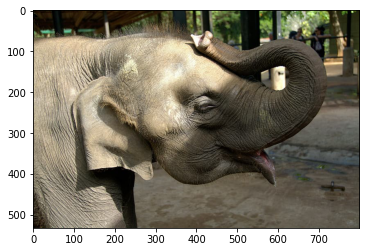

In [ ]:
with open("ilsvrc2012_wordnet_lemmas.txt", "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

img_url = "https://p0.pikrepo.com/preview/853/907/close-up-photo-of-gray-elephant.jpg"
image, preprocessed_image = load_image_from_url(img_url)

plt.imshow(image)
plt.show()

In [ ]:
predictions = vit_dino_base.predict(preprocessed_image)
logits = predictions[0]
predicted_label = imagenet_int_to_str[int(np.argmax(logits))]
expected_label = "Indian_elephant, Elephas_maximus"
assert (
    predicted_label == expected_label
), f"Expected {expected_label} but was {predicted_label}"